---

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Importing all the required Libraries.

In [1]:
import numpy as np #for mathematical operations.
import cv2 #for all image related operations.
import matplotlib.pyplot as plt #for plotting the images.
import matplotlib.image as mpimg 
import glob
from moviepy.editor import VideoFileClip #for implementing our pipeline on the video.
from IPython.display import HTML

### Compute camera calibration matrix and distortion coefficients for a set of chessboard images.

The 'object points' referred as 'objp' here, is to get the (x,y,z) coordinates of chessboard corners. As discussed in the classroom, the x,y considered is 9,6 respectively, with z=0 for the sample 2D images. 
The method 'calibraion' performs 2 operations namely,
'cv2.findChessboardCorners()' which helps in determining a particular pattern of an image.
'cv2.drawChessboardCorners()'.

'cv2.calibrateCamera': returns the Camera_matrix with the focal_length and centre parameters of the camera, the distortion coefficients, the radial & tangential vector arrays.

In [2]:
# prepare object points
nx = 9#number of inside corners in x
ny = 6#number of inside corners in y

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints=[]
imgpoints=[]

offset=100

image_list=glob.glob('./camera_cal/calib*.jpg')
def calibration(image_list):
    for index,fname in enumerate(image_list):
        img=cv2.imread(fname)
        
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #print(gray.shape[::-1])
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if(ret==True):
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            
            
calibration(image_list)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,(1280,720), None, None)

### Apply a distortion correction to raw images.

the 'cal_undistort' function takes the raw images and returns the undistorted images, with the help of 'cv2.undistort' method of cv2 library, which requires the Camera_matrix and distortion_coefficients as input.

In [3]:
def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, None)
    return undist

#### Printing an example of Original and it's Undistorted image.

True

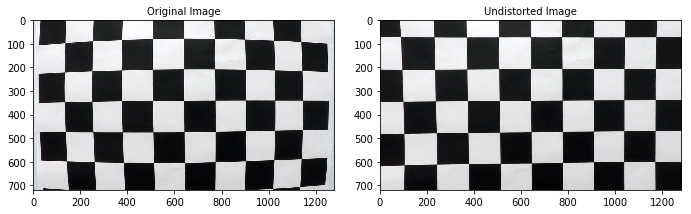

In [4]:
img=cv2.imread('./camera_cal/calibration1.jpg')
undistorted = cal_undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/undistorted.jpg',undistorted)

### Use color transforms, gradients, etc., to create a thresholded binary image.

The below function: 'color_magnitude3()' takes the undistorted image as input.
I have applied Color Thresholding only, for the function to generate a binary image which would help in identifying the lane lines accurately.
I have applied thresholding on 3 single-color channels of different color-space of the same image ,

*Gray :
Thresholding for Gray channel image with threshold in range (180,255) to identify the lane portions.

*Red :
Thresholding for Red channel image of RGB space with threshold in range (200,255) to identify the lane portions.

*Saturation :
Thresholding for Saturation channel image of HLS space with threshold in range (180,255) to identify the lane portions.

**Combination of the above has been used with the help of relative operator, to produce the final Binary_image with the Combined Threshold.

In [5]:
def color_magnitude3(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh_gray = (180, 255)    
    binary_gray= np.zeros_like(gray)
    binary_gray[(gray > thresh_gray[0]) & (gray <= thresh_gray[1])] = 1
    
    R=img[:,:,0]
    thresh_r = (200, 255)
    binary_r = np.zeros_like(R)
    binary_r[(R > thresh_r[0]) & (R <= thresh_r[1])] = 1
    
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    S=hls[:,:,2]
    thresh_s = (90, 255)
    #thresh_s = (150, 255)
    binary_s = np.zeros_like(S)
    binary_s[(S > thresh_s[0]) & (S <= thresh_s[1])] = 1
    
    combined_binary = np.zeros_like(binary_s)
    combined_binary[(binary_r==1)|((binary_gray == 1)&(binary_s == 1))] = 1
    return combined_binary

#### Printing an example of image after Color_thresholding .

True

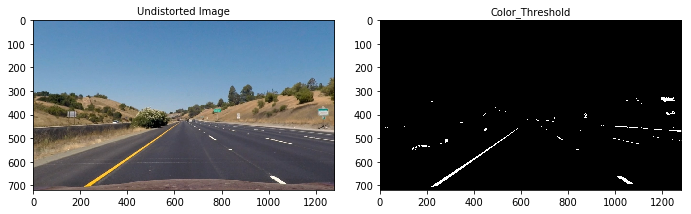

In [6]:
img=mpimg.imread('./test_images/straight_lines1.jpg')
#img2=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undist=cal_undistort(img)

color_mag= color_magnitude3(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=10)
ax2.imshow(color_mag,cmap='gray')
ax2.set_title('Color_Threshold', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/Threshold.jpg',color_mag)

### Apply a perspective transform to rectify binary image ("birds-eye view").

The function 'corners_unwarp()' returns the Perspective_Transform 'M' of the input image using the 'cv2.getPerspectiveTransform()' method, along with the warped image using the 'cv2.warpPerspective()' method. The inverse-perpective transform can be obtained using the same method as that used to get the perspective_Transform, just by swapping the parameter values.
The warped image provides a binary image of the input image having a birds-eye perspective.

I chose to hardcode the source and destination points in the following manner:
```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.


In [7]:
def corners_unwarp(img, nx, ny, mtx, dist):
    #undist = cv2.undistort(img, mtx, dist, None, None)
    # 2) Convert to grayscale
    #gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size=(img.shape[1],img.shape[0])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],    [((img_size[0] / 6) - 10), img_size[1]],    [(img_size[0] * 5 / 6) + 60, img_size[1]],    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]]) 
    dst = np.float32([[(img_size[0] / 4), 0],    [(img_size[0] / 4), img_size[1]],    [(img_size[0] * 3 / 4), img_size[1]],    [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M,img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv


#### Printing an example of image with Bird-Eye view.

True

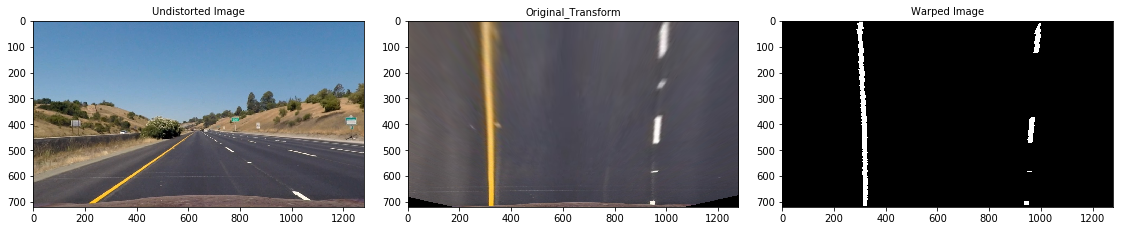

In [8]:
img=mpimg.imread('./test_images/straight_lines1.jpg')
#img2=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undist=cal_undistort(img)

color_mag= color_magnitude3(undist)
persp0,M=corners_unwarp(undist,nx, ny, mtx, dist)
persp1,M=corners_unwarp(color_mag,nx, ny, mtx, dist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=10)
ax2.imshow(persp0)
ax2.set_title('Original_Transform', fontsize=10)
ax3.imshow(persp1,cmap='gray')
ax3.set_title('Warped Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/straight_lines1_Transform.jpg',persp1)
cv2.imwrite('./output_images/straight_lines1_binary_Transform.jpg',persp0)

The following function 'display()' is used to display the images in the list of images that has been passed to it as input.

In [9]:
def display(image_list):
    fig=plt.figure(figsize=(32,32))
    i=0
    for image in image_list:
        i+=1       
        fig.add_subplot(9,5,i)
        if(len(image.shape)==2): #Deciding on the No.of channels in an image.
            plt.imshow(image,cmap='gray')
        else:
            plt.imshow(image)
    plt.show()

### Detect lane pixels and fit to find the lane boundary.

The following function 'find_lines()' takes a binary warped image and determines the 'hot pixels' which are associated with the lane lines, which helps in searching for the lines in an image. We calculate the left_fit and right_fit values for the lanes in an image by first dividing the image into 2 halves horizontally, and then vertically into slabs = the number of windows specified. A rectangle_box is placed such that the pixel with greatest value in a particular slab for both left and right sides is on the centre of the Rectangular_box, hence helping to detect the left and right fit points respectively in each slab.
The curves in an image are detected with the help of a polynomial function of order 2, i.e. x=f(y)

The function is used only for initial frame of an image, as once we have obtained the lane positions, we can continue with the same values as base and start searching for the further frames around the fit values of the previous as the lanes won't drastically change its course.


In [10]:
def find_lines(binary_warped):
   
    #display([binary_warped])
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    #print(histogram)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #print("left_fitx:",left_fitx)
    #print("right_fitx:",right_fitx)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    return out_img,left_fit,right_fit

#### Printing Undistorted image along with the warped image with lane lines detected using find_lines().

True

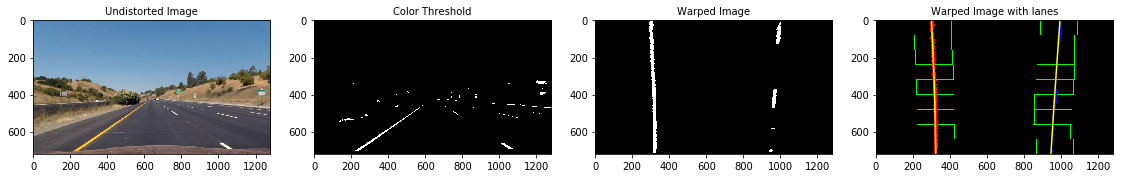

In [11]:
img=mpimg.imread('./test_images/straight_lines1.jpg')
#img2=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undist=cal_undistort(img)

color_mag= color_magnitude3(undist)
persp,M=corners_unwarp(color_mag,nx, ny, mtx, dist)
line_img,left_fit,right_fit=find_lines(persp)
ploty = np.linspace(0, persp.shape[0]-1, persp.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(15, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=10)
ax2.imshow(color_mag,cmap='gray')
ax2.set_title('Color Threshold', fontsize=10)
ax3.imshow(persp,cmap='gray')
ax3.set_title('Warped Image', fontsize=10)
ax4.imshow(line_img,cmap='gray')
ax4.plot(left_fitx, ploty, color='yellow')
ax4.plot(right_fitx, ploty, color='yellow')
ax4.set_title('Warped Image with lanes', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/straight_lines1_find_lines.jpg',line_img)

***The Below function 'find_lines_2()' helps in identifying the left & right fit values for the image frames with the help of left & right fit values of the previous frame, preventing it to again divide the image into various slabs and search for the greatest pixel values in each of them.

In [12]:
def find_lines_2(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #print("left_fitx:",left_fitx)
    #print("right_fitx:",right_fitx)

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #print(left_line_pts)
    #print(right_line_pts)
    return result,left_fit,right_fit
    

#### Printing Undistorted image along with the warped image with lane lines detected using find_lines_2().

True

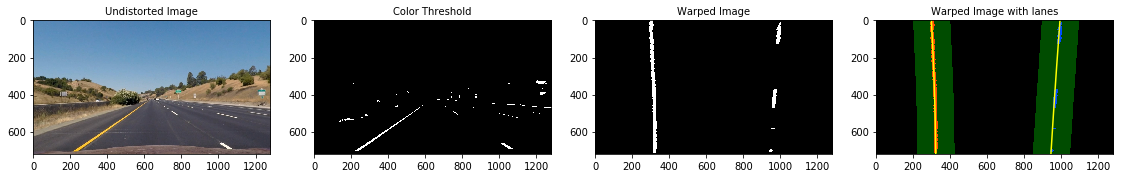

In [13]:
img=mpimg.imread('./test_images/straight_lines1.jpg')
#img2=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undist=cal_undistort(img)

color_mag= color_magnitude3(undist)
persp,M=corners_unwarp(color_mag,nx, ny, mtx, dist)
line_img,left_fit,right_fit=find_lines(persp)
line_img,left_fit,right_fit=find_lines_2(persp,left_fit,right_fit)
ploty = np.linspace(0, persp.shape[0]-1, persp.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(15, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=10)
ax2.imshow(color_mag,cmap='gray')
ax2.set_title('Color Threshold', fontsize=10)
ax3.imshow(persp,cmap='gray')
ax3.set_title('Warped Image', fontsize=10)
ax4.imshow(line_img,cmap='gray')
ax4.plot(left_fitx, ploty, color='yellow')
ax4.plot(right_fitx, ploty, color='yellow')
ax4.set_title('Warped Image with lanes', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/straight_lines1_find_lines2.jpg',line_img)

### Warp the detected lane boundaries back onto the original image.

The below function 'draw_lane()' helps to fill the area between the left and right lane_lines detected in each frame, which helps to visualize the detected lane as a trapezium shape which is the lane area detected onto the original image by applying the "Inverse Perspective Transform" of the detected lane on the bird-eye perspective binary image.

In [14]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result,ploty,left_fitx,right_fitx

#### Printing Undistorted image along with Image with lane detected using draw_lane().

True

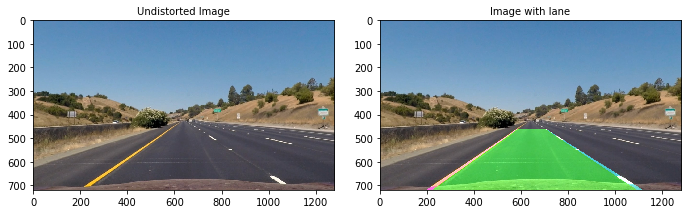

In [15]:
img=mpimg.imread('./test_images/straight_lines1.jpg')
#img2=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undist=cal_undistort(img)

color_mag= color_magnitude3(undist)
persp,Minv=corners_unwarp(color_mag,nx, ny, mtx, dist)
line_img,left_fit,right_fit=find_lines(persp)
img_lane,ploty,left_fitx,right_fitx=draw_lane(undist,persp, left_fit, right_fit, Minv)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=10)
ax2.imshow(img_lane)
ax2.set_title('Image with lane', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./output_images/straight_lines1_draw_lane.jpg',img_lane)

### Determine the curvature of the lane.

The below function 'curvature()' takes the left and right fit points from the 'draw_lane()' function and calculates the curvature for left and  right respectively using the formula, 

R =(1+(2Ay+B)^2)^(3/2))/2A

where,
A,B are the coefficients of 2nd Order Polynomial function.
R- Curvature


In [16]:
def curvature(ploty,leftx,rightx):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad,right_curverad

### Determine the Vehicle position with respect to center 

The Vehicle position is calculated using the following formula,

#### center_pos=((image.shape[1]-(rightx[-1]+leftx[-1]))/2)*(3.7/700)

where,
for every frame the middle of the bottom left & right coordinates( (leftx[-1]+rightx[-1])/2 )are taken and subtracted from the horizontal center ( image.shape[1]/2 )of the image and the result is multiplied with the scale value :(3.7/700) i.e. the meters per pixels in x coordinate.

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Following is the 'pipeline' method that is implemented using all the previous defined functions which are stacked up in a particular order so as to receive an image which maps the lane area along with other details such as Curvature and Vehicle position on the original image.

In pipeline function, 
I have used 'idx' variable and have declared it as global so as to track every iteration because I would be using the 'find_lines()' function only for the first frame where it would search for lane positions w.r.t left and Right sides and pass the points detected to 'find_lines_2()' function for every next frame.


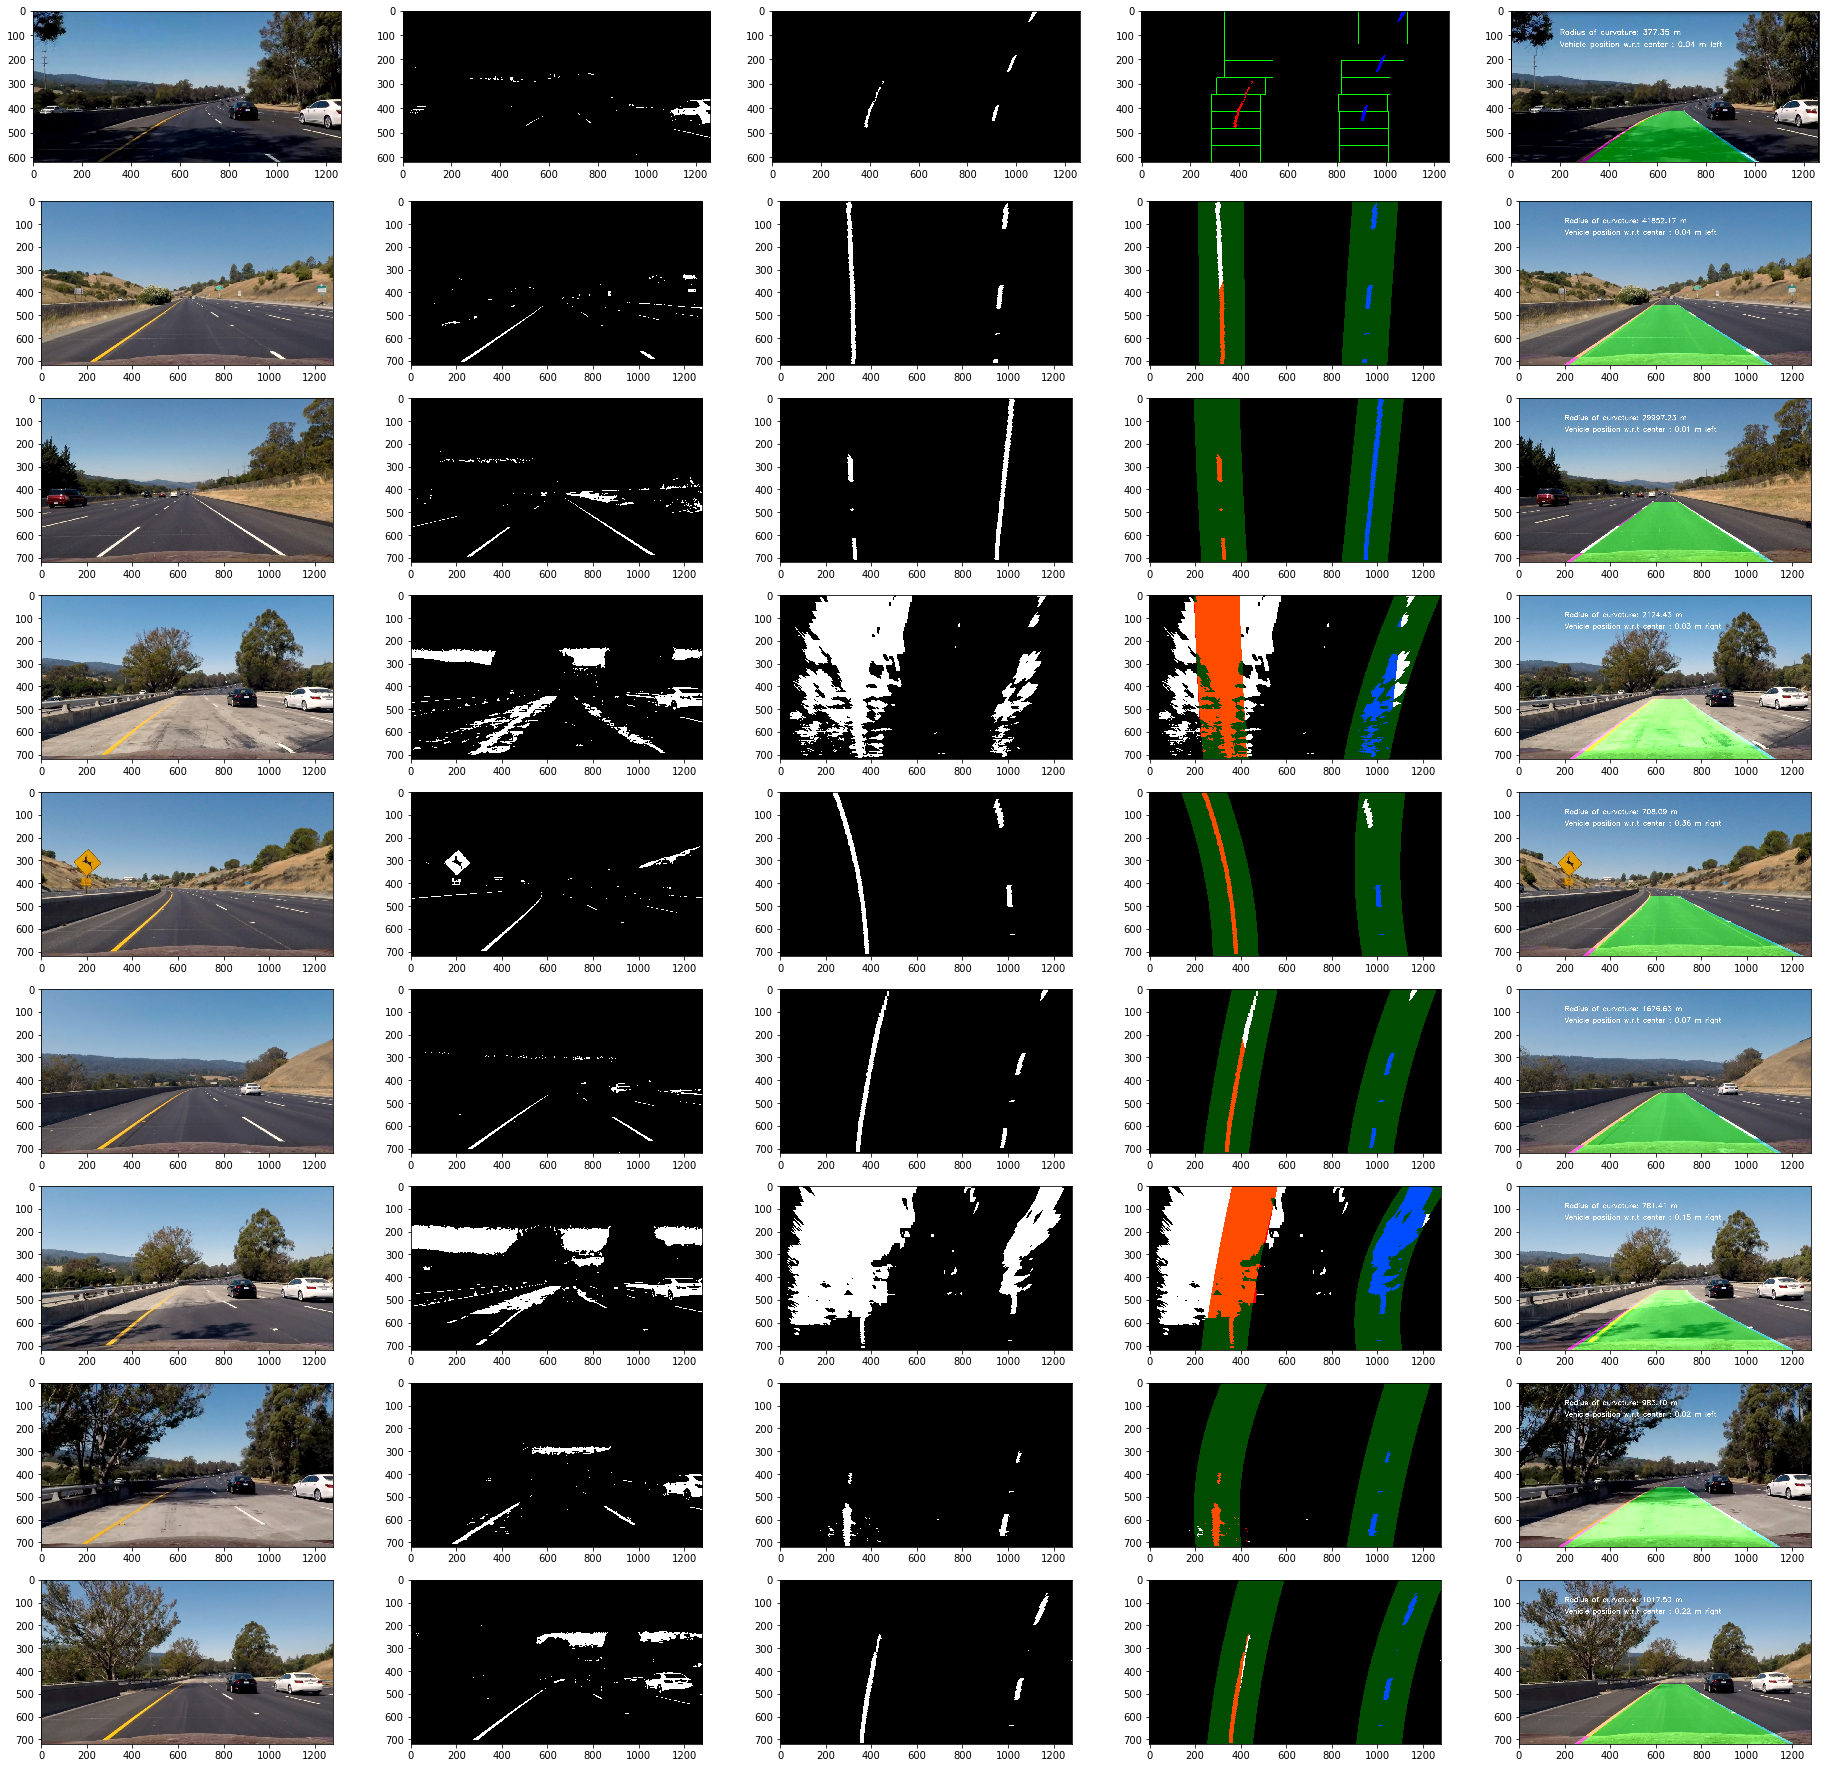

In [17]:
output_images=[]
idx=0
left_fit,right_fit=[],[]


def pipeline(image):
    global idx
    
    global left_fit,right_fit
    
    undist=cal_undistort(image)
    output_images.append(undist)
    #binary_out=color_magnitude_grad(img=undist)
    binary_out=color_magnitude3(img=undist)
    output_images.append(binary_out)
    warped,Minv=corners_unwarp(binary_out,nx, ny, mtx, dist)
    output_images.append(warped)
    if(idx==0):
        #print(indx)
        track_img,l_fit,r_fit = find_lines(warped)
        left_fit=l_fit
        right_fit=r_fit

    else:
        track_img,l_fit,r_fit = find_lines_2(warped,left_fit,right_fit)
        left_fit=l_fit
        right_fit=r_fit
 
    #output.append(histogram)
    output_images.append(track_img)
    res,ploty,leftx,rightx=draw_lane(image, warped, left_fit, right_fit, Minv)
    output_images.append(res)
    lrad,rrad=curvature(ploty,leftx,rightx)
    average=(lrad+rrad)/2
    idx+=1
    font=cv2.FONT_HERSHEY_SIMPLEX
    center_pos=((res.shape[1]-(rightx[-1]+leftx[-1]))/2)*(3.7/700)
    #print(center_pos)
    cv2.putText(res,'Radius of curvature: %.2f m'% average,(200,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    if(center_pos>0):
        cv2.putText(res,'Vehicle position w.r.t center : %.2f m left'% abs(center_pos),(200,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(res,'Vehicle position w.r.t center : %.2f m right'% abs(center_pos),(200,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    return res

images=glob.glob('./test_images/*.jpg')
for idx,fname in enumerate(images):
    #print(idx)
    img=cv2.imread(fname)
    image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #dst = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
    pipeline(image)
    
display(output_images)
idx=0


***The below cell includes code to process the Video by passing the Pipeline function as a parameter.

In [19]:
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4').subclip(10,50)
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

ValueError: t_start (35.00) should be smaller than the clip's duration (16.15).

### Problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Problems were mainly faced during the portion of the video where there is much of the Brightness because of which the 
lane lines and the road color appeared alike,  and also in the shadow part where the right lanes were barely detected, making the mapped lane area shrink and not maintain the required distance between the left and the right lane lines.

One approach would be to calculate the average distance between the 2 sides of the lane lines and when the pipeline is unable to detect the lane line on any one side, we can continue with the average distance and help mark the missed lane line with the help of the lane line position which got detected.